In [ ]:
!pip install pyLDAvis

In [1]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.sklearn

In [2]:
def display_topics(model, features, no_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]],
                                   word_vector[largest[i]]*100.0/total))

In [3]:
df_comments = pd.read_pickle(os.path.join('../output/', '07142022_clean_data.pkl'))
df_comments.head()

,name,comment,published_at,likes,Reply Count,parent_id,is_parent,video_link,date,reply_count,...,impurity,year,month,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,Verb_noun_phrases,lemmasNgrams
0,schmoyoho,Stream the track! https://open.spotify.com/alb...,2018-07-12T18:42:05Z,13998,189,UgywoWu8TaqkOzGi8HF4AaABAg,Yes,Bed Intruder,NaT,NaN,...,0.0,2018,07,"[stream, track, httpsopen.spotify.comalbum6vw3...","[stream, proceed, great]","[track, httpsopen.spotify.comalbum6vw3oxeqedqc...",[track_httpsopen.spotify.comalbum6vw3oxeqedqci...,[great_gift],[],"[stream, track, httpsopen.spotify.comalbum6vw3..."
1,j • d i,youtube bros tho 😸🤍🎼👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻 lol,2022-05-15T14:29:59Z,0,0,UgyfeNHiP8lcSxAr2qB4AaABAg,Yes,Bed Intruder,NaT,NaN,...,0.0,2022,05,"[youtube, bro, tho, lol]",[],"[youtube, bro, tho, lol]",[youtube_bro],[],[],"[youtube, bro, tho, lol]"
2,Lonn Roberts,this songs been in my head all day,2022-05-15T03:42:37Z,0,0,UgxHvi5Eu_iPCzenYkN4AaABAg,Yes,Bed Intruder,NaT,NaN,...,0.0,2022,05,"[song, head, day]",[],"[song, head, day]",[],[],[],"[song, head_day]"
3,Weapon,Peak internet glory days,2022-05-14T19:55:01Z,1,0,UgwzacFLCUiYgSpm2554AaABAg,Yes,Bed Intruder,NaT,NaN,...,0.0,2022,05,"[peak, internet, glory, day]",[],"[peak, internet, glory, day]","[internet_glory, internet_glory_day, glory_day]",[],[],"[peak_internet, glory_day]"
4,sbi,So my question. Did they find the rapist is Li...,2022-05-14T16:47:53Z,0,0,UgxxcUMzPyuHt7dpoqB4AaABAg,Yes,Bed Intruder,NaT,NaN,...,0.0,2022,05,"[question, find, rapist, lincoln, park]",[find],"[question, rapist, lincoln, park]",[],[],[],"[question_find, rapist_lincoln, park]"


In [4]:
df_comments.columns

Index(['name', 'comment', 'published_at', 'likes', 'Reply Count', 'parent_id',
       'is_parent', 'video_link', 'date', 'reply_count', 'comment_lower',
       'clean_comments', 'impurity', 'year', 'month', 'lemmas', 'adjs_verbs',
       'nouns', 'noun_phrases', 'adj_noun_phrases', 'Verb_noun_phrases',
       'lemmasNgrams'],
      dtype='object')

In [5]:
df_comments["paragraphs"] = df_comments["clean_comments"].map(lambda text: re.split('[.?!]\s*\n', text))

<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
/var/folders/8r/h6d_m6c551n1g87q75lclwz40000gn/T/ipykernel_84928/430194434.py:1: DeprecationWarning: invalid escape sequence \s
  df_comments["paragraphs"] = df_comments["clean_comments"].map(lambda text: re.split('[.?!]\s*\n', text))


##### LDA Analysis #####

In [7]:
# LDA Analysis
for video_links in df_comments.video_link.unique():

    df = df_comments[df_comments['video_link'] == video_links]
    print(video_links)
    tfidf_text = TfidfVectorizer(stop_words=stopwords, min_df=10, max_df=0.75)
    vectors_text = tfidf_text.fit_transform(df['clean_comments'])
    print(vectors_text.shape)

      # flatten the paragraphs keeping the years
    paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year } for paragraphs, year in
                                 zip(df["paragraphs"], df["year"])
                                 for paragraph in paragraphs if paragraph])
    tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=10,
                                            max_df=0.75)
    tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
    print(tfidf_para_vectors.shape)

    count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=10,max_df=0.75)
    count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])

    lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
    W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
    H_lda_para_matrix = lda_para_model.components_

    display_topics(lda_para_model, count_para_vectorizer.get_feature_names())

    # Display
    lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors,
                                           count_para_vectorizer, sort_topics=False)
    pyLDAvis.display(lda_display)
    #pyLDAvis.save_html(lda_display, os.path.join('../output',f'{video_links}_lda.html'))

Bed Intruder
(136591, 4074)


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(135186, 4074)


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Topic 00
 rapist (4.78)
 park (2.96)
 hes (2.73)
 lmao (2.66)
 old (1.86)

Topic 01
 dumb (10.05)
 real (6.00)
 song (5.11)
 haha (4.61)
 intruder (3.81)

Topic 02
 guy (7.90)
 love (7.53)
 end (3.74)
 antoine (3.73)
 song (3.19)

Topic 03
 like (10.90)
 best (4.79)
 cover (4.55)
 youtube (3.90)
 song (2.87)

Topic 04
 thumbs (8.63)
 find (8.55)
 awesome (4.85)
 better (3.24)
 video (3.18)

Topic 05
 hide (22.20)
 kids (10.91)
 wife (8.94)
 yo (8.74)
 found (3.35)

Topic 06
 shit (6.97)
 ya (4.16)
 song (3.74)
 got (3.52)
 time (2.82)

Topic 07
 people (9.22)
 tell (6.35)
 run (6.00)
 find (4.56)
 home (4.31)

Topic 08
 funny (4.98)
 dont (3.54)
 cant (3.23)
 know (2.86)
 years (2.55)

Topic 09
 lol (15.52)
 good (5.24)
 views (4.38)
 song (2.71)
 video (2.49)


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ab

Sweet Brown


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(76181, 2279)


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(74056, 2279)


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Topic 00
 song (14.85)
 good (4.90)
 best (4.76)
 like (3.62)
 cant (3.28)

Topic 01
 time (28.49)
 got (25.89)
 aint (20.10)
 dat (6.76)
 fo (3.14)

Topic 02
 dont (5.30)
 people (4.94)
 know (3.41)
 youtube (2.81)
 video (2.48)

Topic 03
 watching (5.68)
 pop (5.37)
 cold (4.48)
 im (3.79)
 itunes (3.27)

Topic 04
 jesus (22.31)
 oh (12.01)
 lol (11.08)
 lord (10.87)
 said (6.83)

Topic 05
 haha (3.78)
 internet (2.88)
 comment (2.87)
 guy (2.63)
 like (2.38)

Topic 06
 funny (10.50)
 old (3.97)
 years (2.95)
 lol (2.92)
 times (2.73)

Topic 07
 love (13.68)
 awesome (5.38)
 day (3.30)
 fucking (2.74)
 cool (2.49)

Topic 08
 xd (12.70)
 like (6.41)
 sweet (5.57)
 brown (4.96)
 better (4.54)

Topic 09
 video (5.62)
 right (2.38)
 whats (2.30)
 omg (2.05)
 views (2.00)


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


Annoying Orange
(22140, 665)


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(21930, 665)


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Topic 00
 lol (17.96)
 song (16.25)
 love (9.02)
 end (3.52)
 nice (3.22)

Topic 01
 eggplant (6.35)
 brittani (5.98)
 taylor (5.27)
 like (4.92)
 omg (3.71)

Topic 02
 orange (20.80)
 antonie (11.87)
 ftw (11.70)
 funny (10.37)
 better (6.51)

Topic 03
 video (5.56)
 got (4.95)
 people (4.37)
 intruder (3.38)
 wow (3.00)

Topic 04
 knife (36.87)
 xd (15.20)
 antione (9.87)
 scared (3.22)
 pepper (2.80)

Topic 05
 orange (35.93)
 ftw (31.64)
 antoine (31.19)
 comments (0.22)
 wtf (0.21)

Topic 06
 apple (12.26)
 best (6.05)
 hey (5.37)
 youre (4.03)
 hahaha (3.51)

Topic 07
 thats (5.43)
 blt (3.58)
 find (3.21)
 funny (2.99)
 way (2.94)

Topic 08
 annoying (14.65)
 orange (13.01)
 thumbs (8.12)
 win (3.56)
 dont (3.15)

Topic 09
 hide (14.40)
 kids (5.72)
 yo (5.21)
 tell (5.12)
 wife (4.83)


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


Justice League
(1174, 231)
(1023, 231)


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of Data


Topic 00
 racism (6.95)
 white (6.21)
 people (6.17)
 guy (5.10)
 mean (4.06)

Topic 01
 people (9.31)
 black (8.41)
 hes (4.65)
 laugh (4.04)
 like (3.19)

Topic 02
 people (7.86)
 funny (6.95)
 im (6.14)
 dont (4.09)
 racism (2.68)

Topic 03
 justice (10.23)
 league (8.10)
 real (4.14)
 tell (3.63)
 thought (3.52)

Topic 04
 man (6.33)
 brown (6.08)
 sweet (6.08)
 video (4.87)
 antoine (2.76)

Topic 05
 kai (11.09)
 read (5.13)
 black (4.30)
 stop (2.83)
 hatchet (2.74)

Topic 06
 people (7.31)
 good (3.14)
 racist (3.06)
 like (2.95)
 racism (2.46)

Topic 07
 thats (9.17)
 think (7.94)
 got (6.13)
 better (5.61)
 time (4.74)

Topic 08
 smash (6.46)
 right (5.05)
 reddit (5.03)
 youtube (4.65)
 httpwww (4.46)

Topic 09
 racist (12.75)
 people (12.73)
 black (9.55)
 white (6.58)
 like (5.54)
World Star
(478, 35)
(476, 35)


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(



Topic 00
 hot (23.70)
 video (22.31)
 hilarious (20.93)
 best (17.73)
 sht (11.17)

Topic 01
 ya (39.39)
 kids (21.41)
 funniest (13.24)
 im (5.07)
 lol (5.07)

Topic 02
 dis (23.13)
 song (21.59)
 ngga (18.53)
 damn (12.40)
 lmfao (8.18)

Topic 03
 lol (67.77)
 omg (20.29)
 damn (7.34)
 im (0.14)
 genius (0.14)

Topic 04
 im (24.16)
 seen (24.16)
 love (19.36)
 news (12.96)
 funniest (8.16)

Topic 05
 like (34.93)
 lmfao (34.35)
 good (26.09)
 need (0.14)
 rape (0.14)

Topic 06
 lmao (59.64)
 got (18.91)
 need (9.47)
 thats (4.28)
 news (3.24)

Topic 07
 funny (61.11)
 hell (14.96)
 rape (10.50)
 dis (5.92)
 sht (2.88)

Topic 08
 tell (30.70)
 run (25.61)
 thats (17.13)
 genius (17.13)
 best (2.38)

Topic 09
 better (28.60)
 real (26.57)
 dat (24.09)
 end (10.34)
 need (2.29)


/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def wordcloud_topics(model, features, no_top_words=25):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100,
                       width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(6,6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

/Users/abhinavbajpai/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


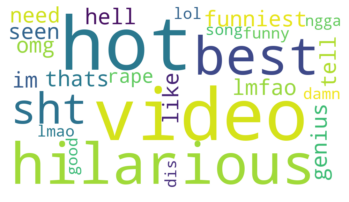

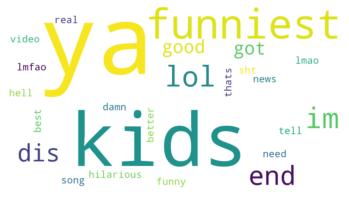

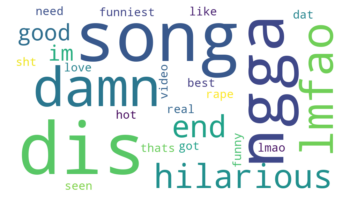

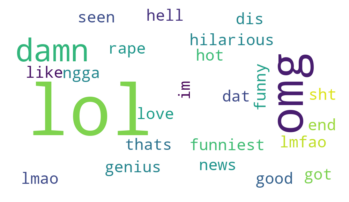

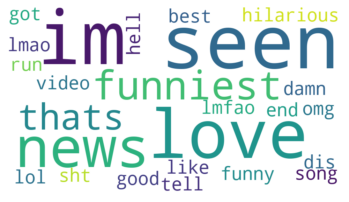

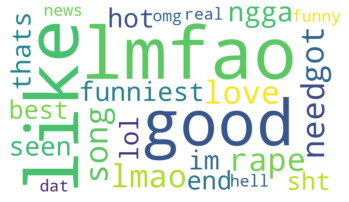

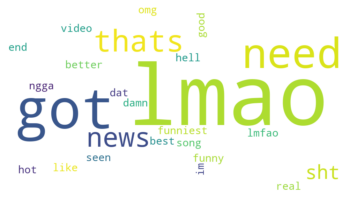

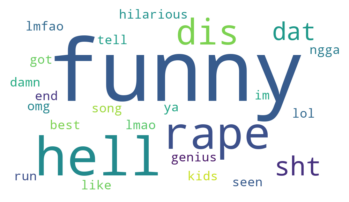

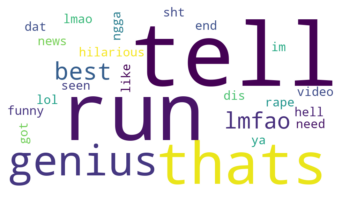

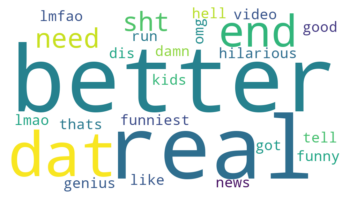

In [9]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names())